## rf tree classifier for classifying trafficking vs non-trafficking

Need to install
- graphviz
- sklearn
- pydotplus
- mlxtend

Installs pydotplus for plotting of datatrees, since its not provided w default session. also installing graphviz

In [1]:
#!pip3 install pydotplus
#!pip3 install mlxtend

### Load requisite libraries

In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import itertools
import matplotlib.gridspec as gridspec

%matplotlib inline
%reload_ext autoreload
%autoreload 2

#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, plot_roc_curve

from mlxtend.data import iris_data
from sklearn.utils import resample

from sklearn.feature_selection import SelectFromModel

import os
import math
from math import floor, ceil

Stuff for plotting trees

In [2]:
from six import StringIO
#from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

plot data

In [3]:
def plotDT(dtree,featureNames = None,classNames=None):
    dot_data = StringIO()
    export_graphviz(dtree, 
                    out_file=dot_data,  
                    feature_names = featureNames,
                    class_names =  classNames,
                    filled=True, 
                    rounded=True,
                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    l=Image(graph.create_png())
    return l

In [4]:
def TestAccuracy(clf,X_test,y_test, display=False):
    
    y_pred  = clf.predict( X_test.values)  
    results = ( y_test.values[:,0]==y_pred )

    if display:
        nEntries, dummy = X_test.shape
        for i in range(nEntries):
            print(X_test.iloc[i])
            print("Class=%s Prediction %s %s\n"%(y_test.values[i,0],y_pred[i],results[i]) )
        #print("prediction",results)

    # accuracy
    nTrue = np.sum( results )
    nTot = np.float( np.shape( results)[0] )
    accuracy = nTrue/nTot
    print("Overall accuracy ",accuracy)

    
def TestAccuracySingle(clf,X_test,Y_test,idx=0):
    
    print(X_test.iloc[idx])
    result = clf.predict( [X_test.values[idx,:]])
    print("prediction",result)
    #print(Y_test.iloc[idx])

In [6]:
#TestAccuracy(clf_entropy,X_test,Y_test,display=True)

### Example with PAS data 

In [5]:
import pandas as pd

In [6]:
os.getcwd()

'/home/xfang2/repos/herg'

In [9]:
#os.chdir('/Users/drkal/Desktop/professional/peter-lab/herg-project/machine-learning/my-work/rf/pas-domain-md')

In [9]:
dataFile = "feature_sets/features-latest-sets1n2.txt"

#tab seperated columns
#df = pd.read_csv(dataFile, sep="\t", comment='#')
#df = pd.read_csv("data/cereal.csv", skiprows = 1)

#space seperated columns
#df = pd.read_csv(dataFile, delimiter=" ", comment='#')

#variable seperated columns use "\s+"
df = pd.read_csv(dataFile, sep="\s+", comment='#')

#df.columns = df.iloc[0]
#df=df.drop(df.index[0])
#print(df.head(5))
df.head()

,VARIANT,HELIX,TURNS,COILS,THREE-TEN,BETA,ISOLATED,RMSD,HBONDS,SASA,WATERS,FOLDX,CONSERVATION,HYDROPHOBICITY,CLASS,TRAFFICKING
0,a32t,21.1567,21.2058,14.4202,3.29401,39.6439,0.279349,1.23560,66.7186,6473.83,1479.93,3.763310,-0.549,-0.43,1,1
1,a57p,20.4290,21.8332,14.5935,3.53135,39.4690,0.144014,1.28151,66.0936,6477.76,1526.79,-0.764827,-0.312,-0.32,0,1
2,a78p,20.8206,21.3096,14.5379,3.19232,39.9190,0.220522,1.12505,65.8526,6479.56,1474.41,0.759351,1.487,-0.32,1,1
3,a85v,20.8686,21.4237,14.6775,3.12031,39.6774,0.232523,1.16450,65.4562,6544.62,1492.34,2.430410,-0.518,0.29,1,1
4,c108r,22.1452,21.1476,15.3975,2.75727,38.2283,0.324033,1.58552,62.7131,6753.12,1548.93,6.958320,0.745,-1.84,1,0


In [11]:
#df[row['VARIANT']]

### fix decimals

In [10]:
#df['decimal_place_2'] = df['decimal_place_2'].round(2)
df['HELIX'] = df['HELIX'].round(2)
df['TURNS'] = df['TURNS'].round(2)
df['COILS'] = df['COILS'].round(2)
df['THREE-TEN'] = df['THREE-TEN'].round(2)
df['BETA'] = df['BETA'].round(2)
df['RMSD'] = df['RMSD'].round(2)
df['HBONDS'] = df['HBONDS'].round()
df['SASA'] = df['SASA'].round()
df['WATERS'] = df['WATERS'].round()
df['FOLDX'] = df['FOLDX'].round(2)
df['CONSERVATION'] = df['CONSERVATION'].round(2)
df['HYDROPHOBICITY'] = df['HYDROPHOBICITY'].round(2)

df.head()

,VARIANT,HELIX,TURNS,COILS,THREE-TEN,BETA,ISOLATED,RMSD,HBONDS,SASA,WATERS,FOLDX,CONSERVATION,HYDROPHOBICITY,CLASS,TRAFFICKING
0,a32t,21.16,21.21,14.42,3.29,39.64,0.279349,1.24,67.0,6474.0,1480.0,3.76,-0.55,-0.43,1,1
1,a57p,20.43,21.83,14.59,3.53,39.47,0.144014,1.28,66.0,6478.0,1527.0,-0.76,-0.31,-0.32,0,1
2,a78p,20.82,21.31,14.54,3.19,39.92,0.220522,1.13,66.0,6480.0,1474.0,0.76,1.49,-0.32,1,1
3,a85v,20.87,21.42,14.68,3.12,39.68,0.232523,1.16,65.0,6545.0,1492.0,2.43,-0.52,0.29,1,1
4,c108r,22.15,21.15,15.40,2.76,38.23,0.324033,1.59,63.0,6753.0,1549.0,6.96,0.74,-1.84,1,0


In [11]:
df1=df.drop(columns='ISOLATED')
df1.head()

,VARIANT,HELIX,TURNS,COILS,THREE-TEN,BETA,RMSD,HBONDS,SASA,WATERS,FOLDX,CONSERVATION,HYDROPHOBICITY,CLASS,TRAFFICKING
0,a32t,21.16,21.21,14.42,3.29,39.64,1.24,67.0,6474.0,1480.0,3.76,-0.55,-0.43,1,1
1,a57p,20.43,21.83,14.59,3.53,39.47,1.28,66.0,6478.0,1527.0,-0.76,-0.31,-0.32,0,1
2,a78p,20.82,21.31,14.54,3.19,39.92,1.13,66.0,6480.0,1474.0,0.76,1.49,-0.32,1,1
3,a85v,20.87,21.42,14.68,3.12,39.68,1.16,65.0,6545.0,1492.0,2.43,-0.52,0.29,1,1
4,c108r,22.15,21.15,15.40,2.76,38.23,1.59,63.0,6753.0,1549.0,6.96,0.74,-1.84,1,0


### describe the data

In [14]:
df.describe()

,HELIX,TURNS,COILS,THREE-TEN,BETA,ISOLATED,RMSD,HBONDS,SASA,WATERS,FOLDX,CONSERVATION,HYDROPHOBICITY,CLASS,TRAFFICKING
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,20.800800,21.582133,14.698000,3.074267,39.594133,0.250196,1.241733,65.826667,6505.360000,1473.533333,3.909867,-0.326267,-0.159333,0.733333,0.600000
std,0.871427,0.745283,0.752649,0.424812,0.867415,0.145460,0.165508,1.256048,73.217122,24.819529,5.305551,0.705097,0.859411,0.553449,0.493197
min,16.250000,20.380000,13.560000,0.960000,35.250000,0.050270,1.020000,63.000000,6393.000000,1419.000000,-1.290000,-1.400000,-2.330000,-1.000000,0.000000
25%,20.605000,21.165000,14.240000,2.930000,39.355000,0.166652,1.140000,65.000000,6459.500000,1457.000000,0.705000,-0.810000,-0.580000,1.000000,0.000000
50%,20.940000,21.460000,14.670000,3.090000,39.720000,0.220522,1.190000,66.000000,6487.000000,1469.000000,1.810000,-0.590000,-0.170000,1.000000,1.000000
75%,21.215000,21.780000,15.085000,3.240000,40.180000,0.287279,1.300000,67.000000,6535.500000,1488.000000,4.685000,0.040000,0.385000,1.000000,1.000000
max,22.420000,24.980000,19.030000,4.770000,40.700000,0.853585,1.960000,68.000000,6753.000000,1549.000000,26.360000,2.320000,2.170000,1.000000,1.000000


In [12]:
features=["HELIX","TURNS","COILS","THREE-TEN","BETA","RMSD","HBONDS","SASA","WATERS","FOLDX","CONSERVATION","HYDROPHOBICITY"]
#features1=["TURNS","HBONDS","WATERS","FOLDX","CONSERVATION"]

output = ["TRAFFICKING"]

#X = df[features1]
X = df[features]
Y = df[output]

In [16]:
X.head()
#Y.head()

,HELIX,TURNS,COILS,THREE-TEN,BETA,RMSD,HBONDS,SASA,WATERS,FOLDX,CONSERVATION,HYDROPHOBICITY
0,21.16,21.21,14.42,3.29,39.64,1.24,67.0,6474.0,1480.0,3.76,-0.55,-0.43
1,20.43,21.83,14.59,3.53,39.47,1.28,66.0,6478.0,1527.0,-0.76,-0.31,-0.32
2,20.82,21.31,14.54,3.19,39.92,1.13,66.0,6480.0,1474.0,0.76,1.49,-0.32
3,20.87,21.42,14.68,3.12,39.68,1.16,65.0,6545.0,1492.0,2.43,-0.52,0.29
4,22.15,21.15,15.40,2.76,38.23,1.59,63.0,6753.0,1549.0,6.96,0.74,-1.84


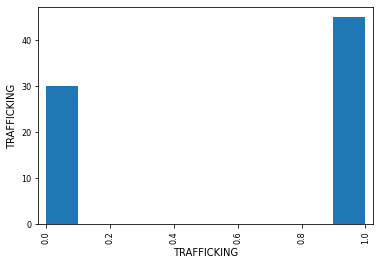

In [13]:
from pandas.plotting import scatter_matrix

#show target data distribution
scatter_matrix(Y)
#plt.show()
plt.savefig('target-data-distribution.pdf')

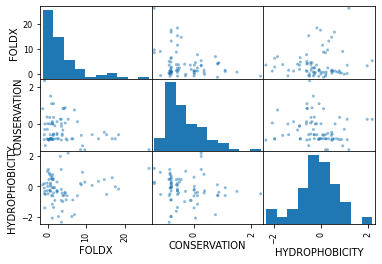

<Figure size 432x288 with 0 Axes>

In [14]:
#show bioinformatics scores spread
sliced = X.iloc[:,9:12]
scatter_matrix(sliced)
plt.show()
plt.savefig('bioinformatics-data-distribution.pdf')
#print(sliced)

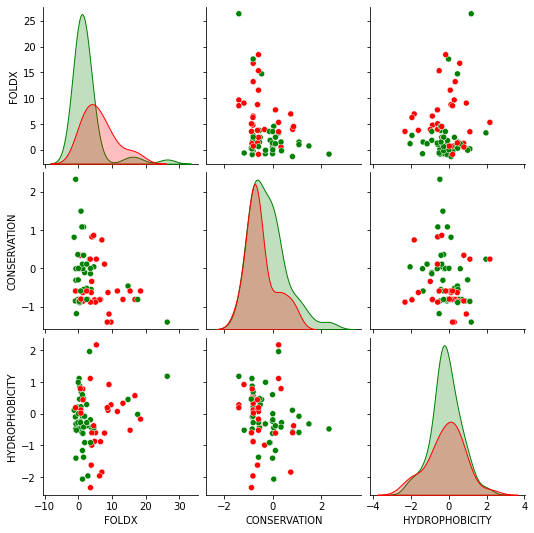

<Figure size 432x288 with 0 Axes>

In [15]:
import seaborn as sns
from sklearn import datasets

df_BIO = df[['FOLDX', 'CONSERVATION', 'HYDROPHOBICITY', 'TRAFFICKING', ]]
# Create pairplot of all the variables with hue set to traff
plot = sns.pairplot(df_BIO, hue='TRAFFICKING', palette=['Red', 'Green']) 
plot._legend.remove()
plt.show()
plt.savefig('bioinformatics-data-distribution2.pdf')

<Figure size 1440x1440 with 0 Axes>

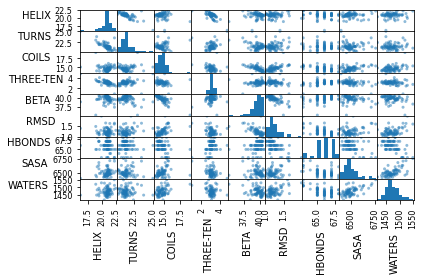

In [16]:
#show md scores spread
plt.figure(figsize=(20,20))

labels = ['HELIX','TURNS','COILS','THREE-TEN','BETA','RMSD','HBONDS','SASA','WATERS']
sliced = X.iloc[:,0:9]
axes = pd.plotting.scatter_matrix(sliced)
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)

plt.savefig('md-distribution.pdf')

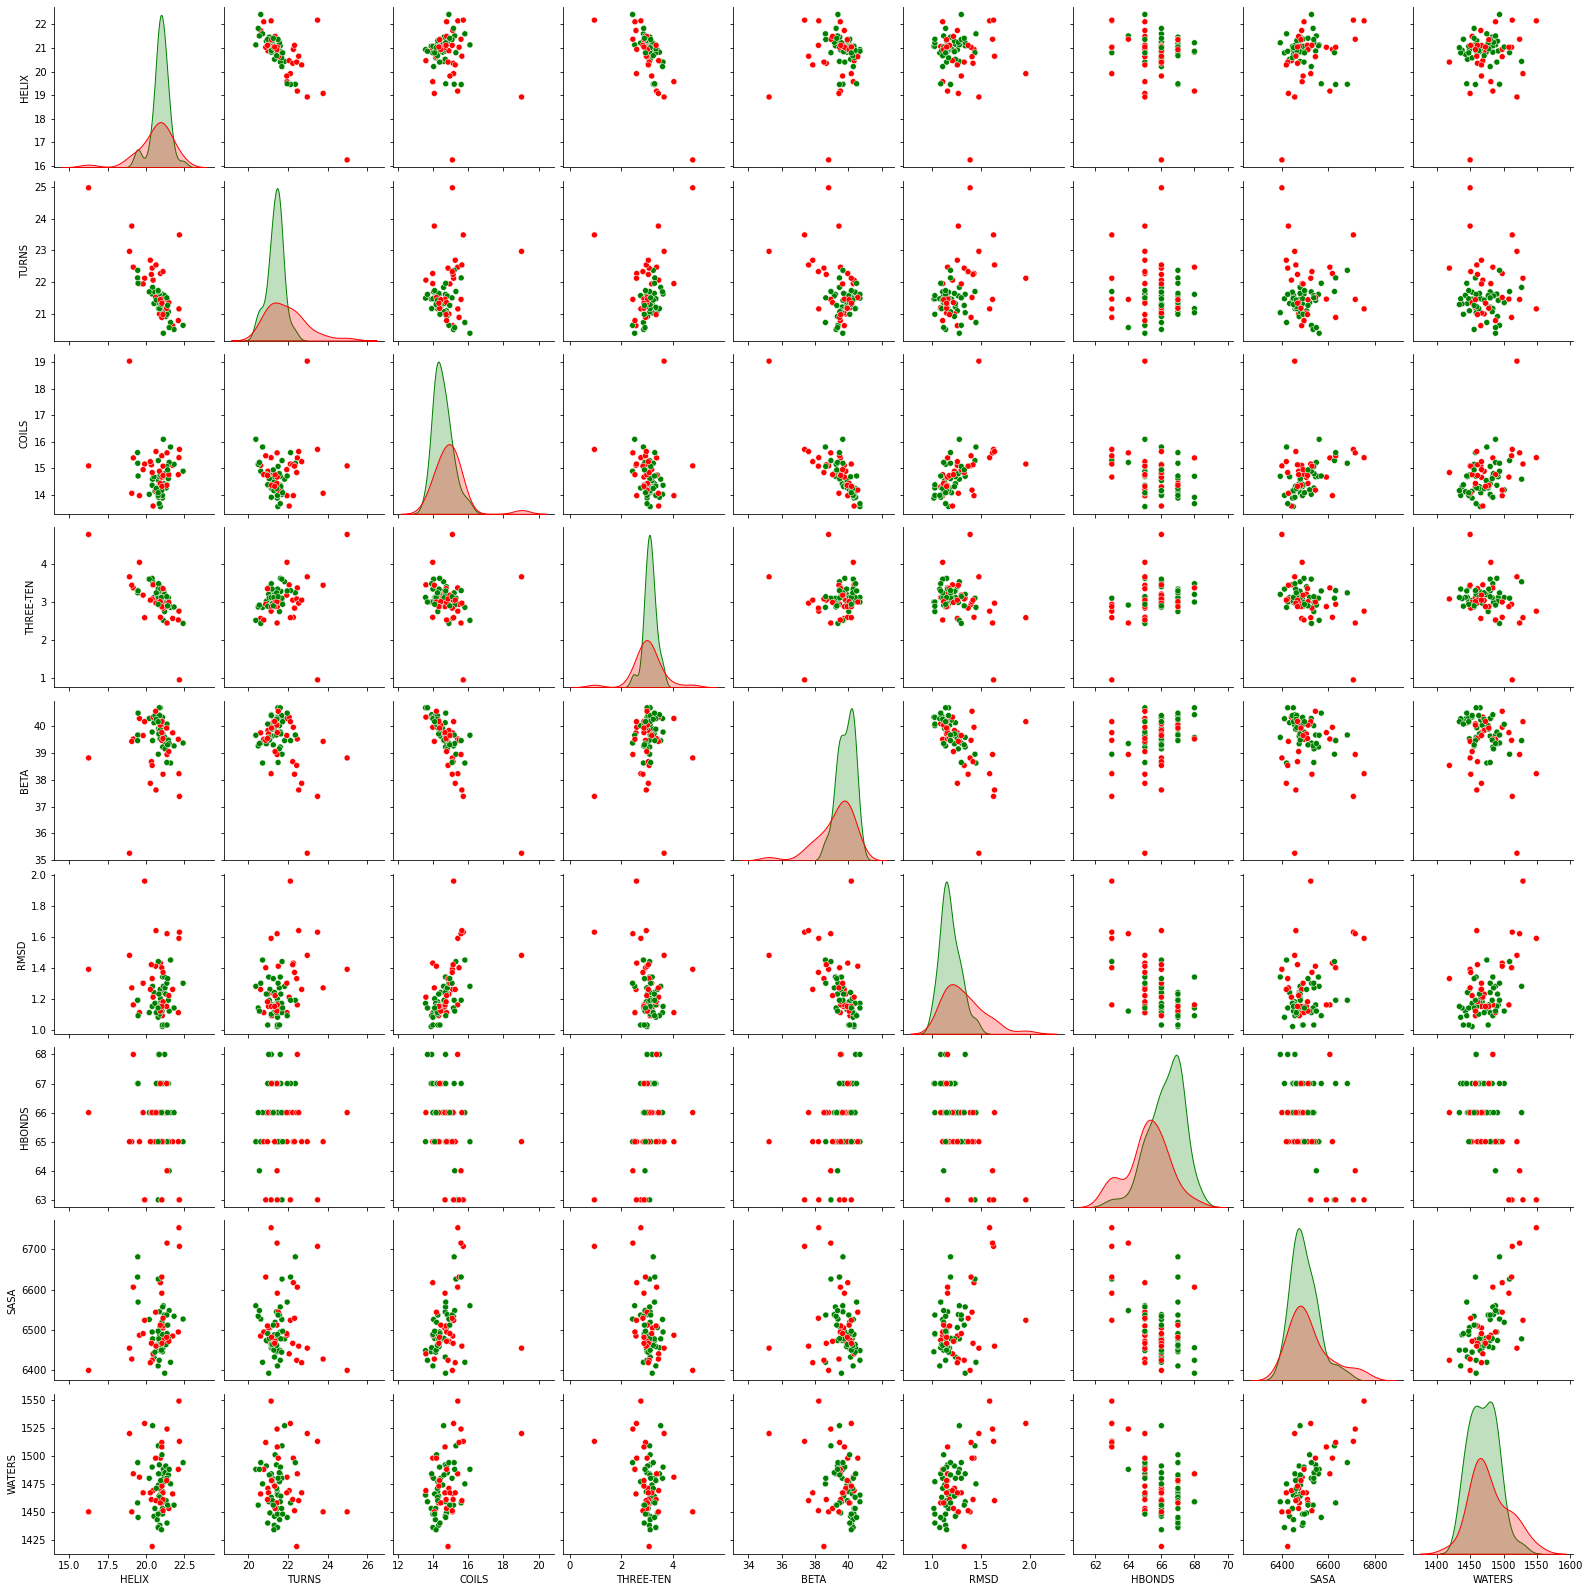

In [17]:
df_MD = df[["HELIX","TURNS","COILS","THREE-TEN","BETA","RMSD","HBONDS","SASA","WATERS", "TRAFFICKING"]]

plot = sns.pairplot(df_MD, hue='TRAFFICKING', palette=['Red', 'Green']) 
plot._legend.remove()
#plot.set_xticklabels(plot.get_xmajorticklabels(), fontsize = 18)

#b = sns.violinplot(y = "Draughts", data = df)
#b.set_yticklabels(b.get_yticks(), size = 15)

plt.savefig('md-data-distribution2.pdf')


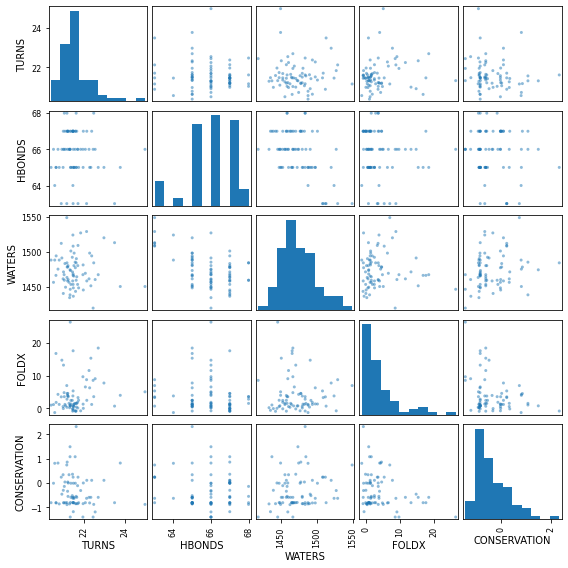

In [18]:
#plt.figure(figsize=(20,20))
#labels = ['HELIX','TURNS','COILS','THREE-TEN','BETA','RMSD','HBONDS','SASA','WATERS']
labels=["TURNS","HBONDS","WATERS","FOLDX","CONSERVATION"]
#sliced = X.iloc[:,0:9]
sliced = df[labels]

axes = pd.plotting.scatter_matrix(sliced, figsize=[8,8])
#plt.axis('square')

for ax in axes.flatten():
    #ax.xaxis.label.set_rotation(90)
    ax.xaxis.label.set_rotation(0)
#    ax.yaxis.label.set_rotation(0)
#    ax.yaxis.label.set_ha('right')

plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0.05, hspace=0.1)

plt.savefig('best-features-distribution.pdf')


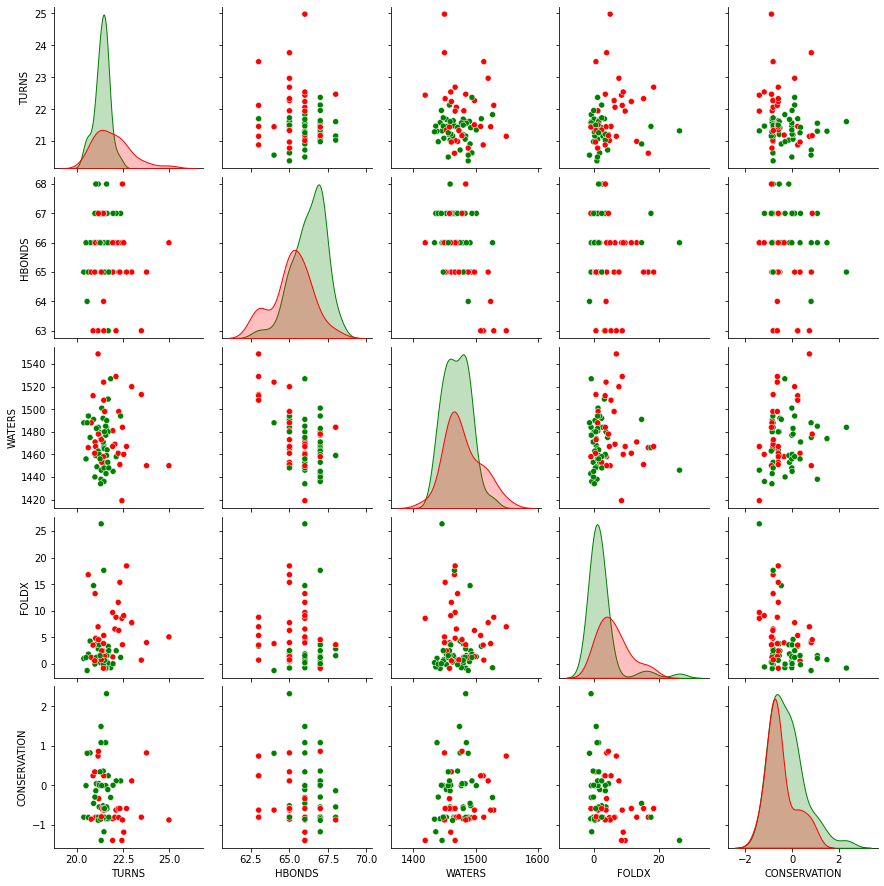

In [19]:
df_best = df[["TURNS","HBONDS","WATERS", "FOLDX", "CONSERVATION", "TRAFFICKING"]]

plot = sns.pairplot(df_best, hue='TRAFFICKING', palette=['Red', 'Green']) 
plot._legend.remove()

#b = sns.violinplot(y = "Draughts", data = df)
#b.set_yticklabels(b.get_yticks(), size = 15)

plt.savefig('best-data-distribution2.pdf')


In [24]:
#figsize=[5,5]
#import seaborn as sns
#labels=["TURNS","HBONDS","WATERS","FOLDX","CONSERVATION"]
#sliced = df[labels]

#sns.set()
#p = sns.pairplot(data=sliced)
#p = sns.lineplot(data = df)
#p.set_xlabel("X-Axis", fontsize = 20)
#p.set_ylabel("Y-Axis", fontsize = 20)
#p.set_title("Plot", fontsize = 20)
#plt.legend(labels=["Legend_Day1","Legend_Day2"], fontsize = 20)

#plt.savefig('best-features-distribution2.pdf')


In [25]:
#data transformation/normalizing
#from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler().fit(X)
#rescaledX = scaler.transform(X)
#np.set_printoptions(precision=3)
#print(rescaledX[0:,:])


###split the data for training

In [20]:
X_train, X_test, Y_train, Y_test =\
train_test_split(X, Y, train_size=0.7, test_size=0.3, random_state=50)


<font color=red> Data looks very unbalanced</font>

In [27]:
### upsample the minority class, which is benign (class 2 = 0)

In [28]:
# concatenate our traning data back together
#C = pd.concat([X_train, Y_train], axis=1)

In [29]:
# seperate minority and majority classes
#group = C.groupby('class')
#benign=list(group)[0][1]
#pathogenic=list(group)[1][1]

In [30]:
#upsample minority
#benign_upsampled = resample(benign,
#                            replace=True, #sample with replacement
#                            n_samples=len(pathogenic), #match number in majority class
#                            random_state=100 #reproduce results
#                           )

In [31]:
#combine majority and upsampled minority
#upsampled = pd.concat([pathogenic, benign_upsampled])

In [32]:
#nEntries = np.shape(Y_train)[0]
#nTrue = np.sum(Y_train=='1')
#print("%f of nEntries are 1"%(nTrue/nEntries))

use "selectFromModel" from sklearn to automatically select the features. SelectFromModel will select those features which importance is greater than the mean importance of all the features by default

In [21]:
#initializing the classifier and fitting it
#clf_rf = RandomForestClassifier(bootstrap=True, n_estimators=100, criterion="entropy", random_state=50)
clf_rf = RandomForestClassifier(bootstrap=True, n_estimators=10000, criterion="entropy", max_depth=None, max_features=4, max_leaf_nodes=None,
min_samples_leaf=1, min_samples_split=2, random_state=50)

#clf_rf = SelectFromModel(RandomForestClassifier(bootstrap=True, n_estimators=100, criterion="entropy"))

In [22]:
# train the classifier with resampled data
#X_train=pd.DataFrame(upsampled, columns=["waters", "hbonds", "rmsd"])
#Y_train=pd.DataFrame(upsampled, columns=["class"])
model=clf_rf.fit(X_train, Y_train.values.ravel())


####k-fold crossvalidation

In [24]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=10, random_state=None)
results = cross_val_score(model, X, Y.values.ravel(), cv=kfold)


In [25]:
print(results)
print(results.mean())


[1.         0.5        0.75       0.75       0.625      0.85714286
 0.71428571 0.57142857 0.71428571 0.71428571]
0.7196428571428571


To see which features are important we can use "get_support" method on the fitted model.

In [37]:
#model.get_support()

In [38]:
#make a list and count the selected features.
#selected_feat= X_train.columns[(model.get_support())]
#len(selected_feat)

In [39]:
#get the name of the features selected
#print(selected_feat)

In [40]:
#pd.Series(model.estimator_,feature_importances_,.ravel()).hist()

In [41]:
#zip now returns an iterable
#for i in zip(features, clf_rf.feature_importances_*100):
#    print (i)

In [26]:
# print training accuracy
print("Training sample accuracy")
TestAccuracy(clf_rf, X_train, Y_train)

Training sample accuracy
Overall accuracy  1.0


/tmp/ipykernel_27879/1182513940.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nTot = np.float( np.shape( results)[0] )


In [27]:
#classNames=np.array(['0', '1']) # need to verify, but I think this is correct
#classNames=np.array(['benign', 'pathogenic']) # need to verify, but I think this is correct
classNames=np.array(['non-trafficking', 'trafficking']) # need to verify, but I think this is correct

In [28]:
#TestAccuracy(clf_entropy,X_test,Y_test, display=True)
print('Test Accuracy')
TestAccuracy(clf_rf,X_test,Y_test)

Test Accuracy
Overall accuracy  0.7391304347826086


/tmp/ipykernel_27879/1182513940.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nTot = np.float( np.shape( results)[0] )


In [29]:
y_predict = clf_rf.predict(X_test)

In [30]:
### Print overall classification metrics
print(classification_report(Y_test, y_predict, target_names=classNames))
#plt.savefig('rf_summary_latest.pdf')

                 precision    recall  f1-score   support

non-trafficking       0.88      0.58      0.70        12
    trafficking       0.67      0.91      0.77        11

       accuracy                           0.74        23
      macro avg       0.77      0.75      0.73        23
   weighted avg       0.78      0.74      0.73        23



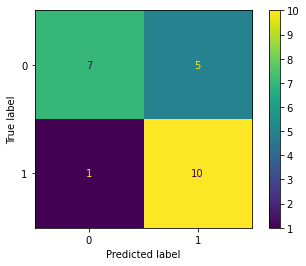

In [31]:
#print(confusion_matrix(Y_test, y_predict))
plot_confusion_matrix(clf_rf, X_test, Y_test)
#plt.savefig('rf_confusion_matrix_latest.pdf')

#extracting metrics for roc curve

In [32]:
y_predict = clf_rf.predict(X_test)
Y_test=np.array(Y_test)
Y_test2=Y_test.reshape(23,)

new_ypredict = [int(y) for y in y_predict]
new_Y_test = [int(f) for f in Y_test2]

#metrics.roc_curve(y_true, y_predict, pos_label=1)
fpr, tpr, thresholds = metrics.roc_curve(new_Y_test, new_ypredict, pos_label=1)
#fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_predict, pos_label=1)

#print ("FPR", fpr*100)
#print ("TPR", tpr*100)
#print ("thresholds", thresholds)

In [33]:
y_predict = clf_rf.fit(X_train,Y_train.values.ravel()).predict_proba(X_test)
fpr, tpr, thr = metrics.roc_curve(Y_test, y_predict[:,1])
auc = metrics.auc(fpr, tpr)

In [50]:
# plot roc curve
#plot_roc_curve(clf_rf, X_test, Y_test)
#plot_roc_curve(clf_rf,X_test, Y_test)
#plt.plot(fpr, tpr, label="RF (AUC=%0.2f)"% auc)
#plt.legend(loc='lower right')
#plt.savefig('rf_roc_mdfeatures_model_latest.pdf')

Text(0.5, 1.0, 'Feature Importances - All Features (RF)')

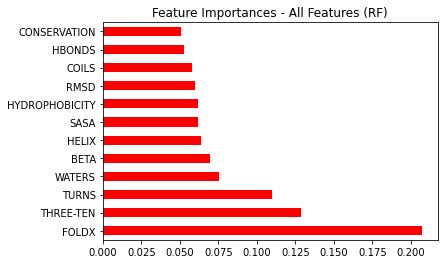

In [34]:
# print feature importance
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh', color="red")
plt.title('Feature Importances - All Features (RF)')
#plt.savefig('rf_fi_allfeatures.png',bbox_inches='tight')

### generate data for ROC curve

In [44]:
HEX = df[['HELIX']]
B = df[["BETA"]]
T = df[["TURNS"]]
C = df[["COILS"]]
TT = df[["THREE-TEN"]]
R = df[["RMSD"]]
W = df[["WATERS"]]
H = df[["HBONDS"]]
S = df[["SASA"]]
F=df[['FOLDX']]
CO=df[["CONSERVATION"]]
HY=df[["HYDROPHOBICITY"]]

Y = df["TRAFFICKING"]
#X = df[features]

#redifined the classifier for one feature
clf2_rf = RandomForestClassifier(bootstrap=True, n_estimators=10000, criterion="entropy", max_depth=None, max_leaf_nodes=None,
min_samples_leaf=1, min_samples_split=2, random_state=50)

y_predict = clf_rf.fit(X_train,Y_train.values.ravel()).predict_proba(X_test)
fpr, tpr, thr = metrics.roc_curve(Y_test, y_predict[:,1])
auc = metrics.auc(fpr, tpr)


#helicity
HEX_train, HEX_test, HEY_train, HEY_test = train_test_split(HEX, Y, train_size=0.7, test_size=0.3, random_state=50)
#modelHE=clf2_rf.fit(HEX_train, HEY_train.values.ravel())
#HEY_predict = clf2_rf.predict(HEX_test.values)
HEY_predict = clf2_rf.fit(HEX_train, HEY_train).predict_proba(HEX_test)
f_helix, t_helix, th_helix = metrics.roc_curve(HEY_test, HEY_predict[:,1], pos_label=1)
helix_auc = metrics.auc(f_helix, t_helix)

#beta
bx_train, bx_test, by_train, by_test = train_test_split(B, Y, train_size=0.7, test_size=0.3, random_state=50)
#modelB=clf2_rf.fit(bx_train, by_train.values.ravel())
#by_predict = clf2_rf.predict(bx_test.values)
by_predict = clf2_rf.fit(bx_train, by_train).predict_proba(bx_test)
f_beta, t_beta, th_beta = metrics.roc_curve(by_test, by_predict[:,1], pos_label=1)
beta_auc = metrics.auc(f_beta, t_beta)

#coil
cx_train, cx_test, cy_train, cy_test = train_test_split(C, Y, train_size=0.7, test_size=0.3, random_state=50)
#modelC=clf2_rf.fit(cx_train, cy_train.values.ravel())
#cy_predict = clf2_rf.predict(cx_test.values)
cy_predict = clf2_rf.fit(cx_train, cy_train).predict_proba(cx_test)
f_coil, t_coil, th_coil = metrics.roc_curve(cy_test, cy_predict[:,1], pos_label=1)
coil_auc = metrics.auc(f_coil, t_coil)

#3-10
ttx_train, ttx_test, tty_train, tty_test = train_test_split(TT, Y, train_size=0.7, test_size=0.3, random_state=50)
#modelTT=clf2_rf.fit(ttx_train, tty_train.values.ravel())
#tty_predict = clf2_rf.predict(ttx_test.values)
tty_predict = clf2_rf.fit(ttx_train, tty_train).predict_proba(ttx_test)
f_tten, t_tten, th_tten = metrics.roc_curve(tty_test, tty_predict[:,1], pos_label=1)
tten_auc = metrics.auc(f_tten, t_tten)

#rmsd
#extract metrics for rmsd. f_rmsd = false positive rate, t_rmsd=true positive rate, th_rmsd=threshold values
rx_train, rx_test, ry_train, ry_test = train_test_split(R, Y, train_size=0.7, test_size=0.3, random_state=50)
#modelR=clf2_rf.fit(rx_train, ry_train.values.ravel())
#ry_predict = clf2_rf.predict(rx_test.values)
ry_predict = clf2_rf.fit(rx_train, ry_train).predict_proba(rx_test)
f_rmsd, t_rmsd, th_rmsd = metrics.roc_curve(ry_test, ry_predict[:,1], pos_label=1)
rmsd_auc = metrics.auc(f_rmsd, t_rmsd)

#extract metrics for sasa
sx_train, sx_test, sy_train, sy_test = train_test_split(S, Y, train_size=0.7, test_size=0.3, random_state=50)
#modelS=clf2_rf.fit(sx_train, sy_train.values.ravel())
#sy_predict = clf2_rf.predict(sx_test.values)
sy_predict = clf2_rf.fit(sx_train, sy_train).predict_proba(sx_test)
f_sasa, t_sasa, th_sasa = metrics.roc_curve(sy_test, sy_predict[:,1], pos_label=1)
sasa_auc = metrics.auc(f_sasa, t_sasa)

#hbonds
#extract metrics for hbonds
hx_train, hx_test, hy_train, hy_test = train_test_split(H, Y, train_size=0.7, test_size=0.3, random_state=50)
#modelH=clf2_dt.fit(hx_train, hy_train.values.ravel())
#hy_predict = clf2_dt.predict(hx_test.values)
hy_predict = clf2_rf.fit(hx_train, hy_train).predict_proba(hx_test)
f_hbonds, t_hbonds, th_hbonds = metrics.roc_curve(hy_test, hy_predict[:,1], pos_label=1, drop_intermediate=False)
hbonds_auc = metrics.auc(f_hbonds, t_hbonds)

#water
#extract metrics for water
wx_train, wx_test, wy_train, wy_test = train_test_split(W, Y, train_size=0.7, test_size=0.3, random_state=50)
#modelW=clf2_dt.fit(wx_train, wy_train.values.ravel())
#wy_predict = clf2_dt.predict(wx_test.values)
wy_predict = clf2_rf.fit(wx_train, wy_train).predict_proba(wx_test)
f_water, t_water, th_water = metrics.roc_curve(wy_test, wy_predict[:,1], pos_label=1)
water_auc = metrics.auc(f_water, t_water)

#turns
tx_train, tx_test, ty_train, ty_test = train_test_split(T, Y, train_size=0.7, test_size=0.3, random_state=50)
#modelT=clf2_dt.fit(tx_train, ty_train.values.ravel())
#ty_predict = clf2_dt.predict(tx_test.values)
ty_predict = clf2_rf.fit(tx_train, ty_train).predict_proba(tx_test)
f_turns, t_turns, th_turns = metrics.roc_curve(ty_test, ty_predict[:,1], pos_label=1, drop_intermediate=False)
turns_auc = metrics.auc(f_turns, t_turns)


#foldx
fx_train, fx_test, fy_train, fy_test = train_test_split(F, Y, train_size=0.7, test_size=0.3, random_state=50)
modelF=clf2_rf.fit(fx_train, fy_train.values.ravel())
#fy_predict = clf2_dt.predict(fx_test.values)
fy_predict = clf2_rf.fit(fx_train, fy_train).predict_proba(fx_test)
f_foldx, t_foldx, th_foldx = metrics.roc_curve(fy_test, fy_predict[:,1], pos_label=1, drop_intermediate=False)
foldx_auc = metrics.auc(f_foldx, t_foldx)

#hydrophobicity
hyx_train, hyx_test, hyy_train, hyy_test = train_test_split(HY, Y, train_size=0.7, test_size=0.3, random_state=50)
#modelHY=clf2_dt.fit(hyx_train, hyy_train.values.ravel())
#hyy_predict = clf2_dt.predict(hyx_test.values)
#hyy_predict = clf2_dt.decision_function(hyx_test.values)
hyy_predict = clf2_rf.fit(hyx_train, hyy_train).predict_proba(hyx_test)
#f_hydr, t_hydr, th_hydr = metrics.roc_curve(hyy_test, hyy_predict)
f_hydr, t_hydr, th_hydr = metrics.roc_curve(hyy_test, hyy_predict[:,1], drop_intermediate=False)
hydr_auc = metrics.auc(f_hydr, t_hydr)

#conservation
cox_train, cox_test, coy_train, coy_test = train_test_split(CO, Y, train_size=0.7, test_size=0.3, random_state=50)
#modelCO=clf2_dt.fit(cox_train, coy_train.values.ravel())
#coy_predict = clf2_dt.predict(cox_test)
coy_score = clf2_rf.fit(cox_train, coy_train).predict_proba(cox_test)
f_cons, t_cons, th_cons = metrics.roc_curve(coy_test, coy_score[:,1], pos_label=1, drop_intermediate=False)
cons_auc = metrics.auc(f_cons, t_cons)

#for i in range(n_classes):
#   fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
#   roc_auc[i] = auc(fpr[i], tpr[i])

KeyboardInterrupt: 

### training a model with subset of features 

In [52]:
X_sub = df[features]
X_sub = df[features].drop(columns=["CONSERVATION", "HYDROPHOBICITY"])
X_sub.head()

,HELIX,TURNS,COILS,THREE-TEN,BETA,RMSD,HBONDS,SASA,WATERS,FOLDX
0,21.16,21.21,14.42,3.29,39.64,1.24,67.0,6474.0,1480.0,3.76
1,20.43,21.83,14.59,3.53,39.47,1.28,66.0,6478.0,1527.0,-0.76
2,20.82,21.31,14.54,3.19,39.92,1.13,66.0,6480.0,1474.0,0.76
3,20.87,21.42,14.68,3.12,39.68,1.16,65.0,6545.0,1492.0,2.43
4,22.15,21.15,15.40,2.76,38.23,1.59,63.0,6753.0,1549.0,6.96


In [53]:
#foldx
clf2_rf = RandomForestClassifier(bootstrap=True, n_estimators=10000, criterion="entropy", max_depth=None, max_leaf_nodes=None,
min_samples_leaf=1, min_samples_split=2, random_state=50)


xsub_train, xsub_test, ysub_train, ysub_test = train_test_split(X_sub, Y, train_size=0.7, test_size=0.3, random_state=50)
modelX_sub = clf2_rf.fit(xsub_train, ysub_train.values.ravel())
ysub_predict = clf2_rf.fit(xsub_train, ysub_train).predict_proba(xsub_test)


fx_train, fx_test, fy_train, fy_test = train_test_split(F, Y, train_size=0.7, test_size=0.3, random_state=50)
modelF=clf2_rf.fit(fx_train, fy_train.values.ravel())
#fy_predict = clf2_dt.predict(fx_test.values)
fy_predict = clf2_rf.fit(fx_train, fy_train).predict_proba(fx_test)




In [55]:
#reshape the data
#sec stru
#HE_new = np.array(HE)
#HE_new = HE_new.reshape(75,)
#HE_new = [int(he) for he in HE_new]

### Plot ROC

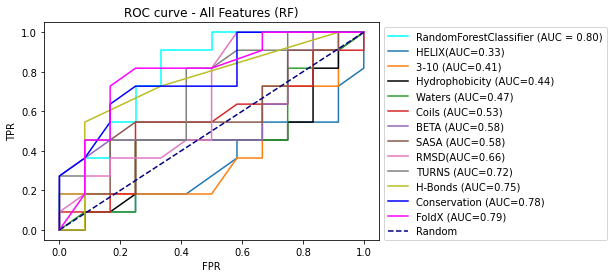

In [56]:
#plot the roc curves of rmsd, waters and hbonds. auc is area under the curve
#plt.figure(figsize=(5, 5))
plot_roc_curve(clf_rf, X_test, Y_test, color='cyan')
plt.plot(f_helix, t_helix, label="HELIX(AUC=%0.2f)"% helix_auc)
plt.plot (f_tten, t_tten, label="3-10 (AUC=%0.2f)"% tten_auc)
plt.plot (f_hydr, t_hydr, color='black', label="Hydrophobicity (AUC=%0.2f)"% hydr_auc)
plt.plot (f_water, t_water, label="Waters (AUC=%0.2f)"% water_auc)
plt.plot (f_coil, t_coil, label="Coils (AUC=%0.2f)"% coil_auc)
plt.plot (f_beta, t_beta, label="BETA (AUC=%0.2f)"% beta_auc)
plt.plot (f_sasa, t_sasa, label="SASA (AUC=%0.2f)"% sasa_auc)
plt.plot(f_rmsd, t_rmsd, label="RMSD(AUC=%0.2f)"% rmsd_auc)
plt.plot (f_turns, t_turns, label="TURNS (AUC=%0.2f)"% turns_auc)
plt.plot (f_hbonds, t_hbonds, label="H-Bonds (AUC=%0.2f)"% hbonds_auc)
plt.plot (f_cons, t_cons, color='blue', label="Conservation (AUC=%0.2f)"% cons_auc)
plt.plot (f_foldx, t_foldx, color='magenta', label="FoldX (AUC=%0.2f)"% foldx_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random')

plt.title('ROC curve - All Features (RF)')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc="lower right")

plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.savefig('rf_roc_all_features.pdf', bbox_inches='tight')

###plot just the model

In [57]:
#plot_roc_curve(clf_rf, X_test, Y_test)
#plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random')

#plt.title('ROC curve-All features (RF)')
#plt.xlabel("FPR")
#plt.ylabel("TPR")
#plt.legend(loc="upper left")

#plt.legend(loc='lower right')
#plt.savefig('rf_roc_all_features_onlymodel.pdf', bbox_inches='tight')

In [58]:
#import math
#from math import floor, ceil

#print ("FPR-RMSD", f_rmsd)
#print ("TPR-RMSD", t_rmsd)
#print ("thresholds-RMSD", th_rmsd)

##### roc metrics for bioinformatics and md models

In [59]:
bio_fpr = np.array([0., 0., 0., 0.16666667, 0.16666667, 0.41666667, 0.41666667, 0.5, 0.5       , 1.        ])
bio_tpr = np.array([0., 0.09090909, 0.36363636, 0.36363636, 0.81818182, 0.81818182, 0.90909091, 0.90909091, 1., 1.])
bio_auc = 0.8409090909090908

md_fpr = np.array([0., 0., 0., 0.08333333, 0.08333333, 0.41666667, 0.41666667, 0.5, 0.5, 0.58333333, 0.58333333, 1.])
md_tpr = np.array([0., 0.09090909, 0.27272727, 0.27272727, 0.36363636, 0.36363636, 0.63636364, 0.63636364, 0.90909091, 0.90909091, 1., 1.])
md_auc = 0.6893939393939394

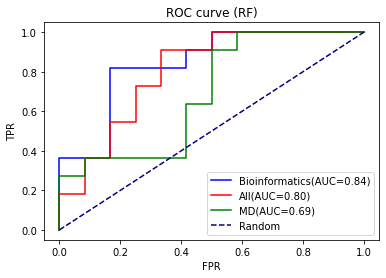

In [60]:
#plot_roc_curve(clf_rf, X_test, Y_test, color='red', label="All(AUC=%0.2f)")
plt.plot (bio_fpr, bio_tpr, color='blue', label="Bioinformatics(AUC=%0.2f)"%bio_auc)
plt.plot (fpr, tpr, color='red', label="All(AUC=%0.2f)"%auc)
plt.plot (md_fpr, md_tpr, color='green', label="MD(AUC=%0.2f)"%md_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random')

plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('ROC curve (RF)')

#plt.savefig('rf_roc_all_models.pdf', bbox_inches='tight')

##### col e/good reads variants predictions

In [54]:
#dataFilecole = "final-foldxscores.txt"
dataFilecole = "feature_sets/cole_dataset.txt"

df_cole = pd.read_csv(dataFilecole, sep="\s+", comment='#')
df_cole.head()


,VARIANT,FOLDX,VARIANT.1,HELIX,TURNS,COILS,THREE-TEN,BETA,ISOLATED,RMSD,HBONDS,SASA,WATERS,CONSERVATION
0,A79T,-0.049102,A79T,21.6228,21.2128,15.0569,2.60102,39.3429,0.163544,1.27965,65.6247,6559.70,1485.27,0.532
1,C39R,-1.423360,C39R,20.3325,21.2333,14.8515,2.97363,40.4753,0.133756,1.05869,66.4880,6448.80,1453.63,0.349
2,C49S,0.432678,C49S,21.3508,21.1868,15.4224,2.73748,39.0399,0.262601,1.25251,65.3736,6535.40,1465.43,-0.798
3,D119H,0.130417,D119H,20.9646,20.4171,15.3741,3.06922,39.8931,0.281871,1.15795,65.4479,6496.82,1601.38,1.182
4,D46E,0.013278,D46E,21.2072,20.7323,15.2426,3.24756,39.3218,0.248621,1.22506,65.2309,6504.14,1466.84,-0.863


In [55]:
#F_cole=df_cole[['FOLDX']]
F_cole=df_cole[["HELIX","TURNS","COILS","THREE-TEN","BETA","RMSD","HBONDS","SASA","WATERS","FOLDX"]]
                
#cole_predictions = modelF.predict(F_cole)
cole_predictions = modelX_sub.predict(F_cole)

dataframe=pd.DataFrame(cole_predictions)
#dataframe=pd.DataFrame(cole_predictions, df_cole[['VARIANT']])
dataframe.columns =['Prediction']


ValueError: X has 10 features, but DecisionTreeClassifier is expecting 1 features as input.

In [ ]:
frames = [df_cole[['VARIANT']], dataframe]
result = pd.concat(frames, axis=1)
#result.to_csv('good_reads_predictions.txt', index=False, sep="\t")
result


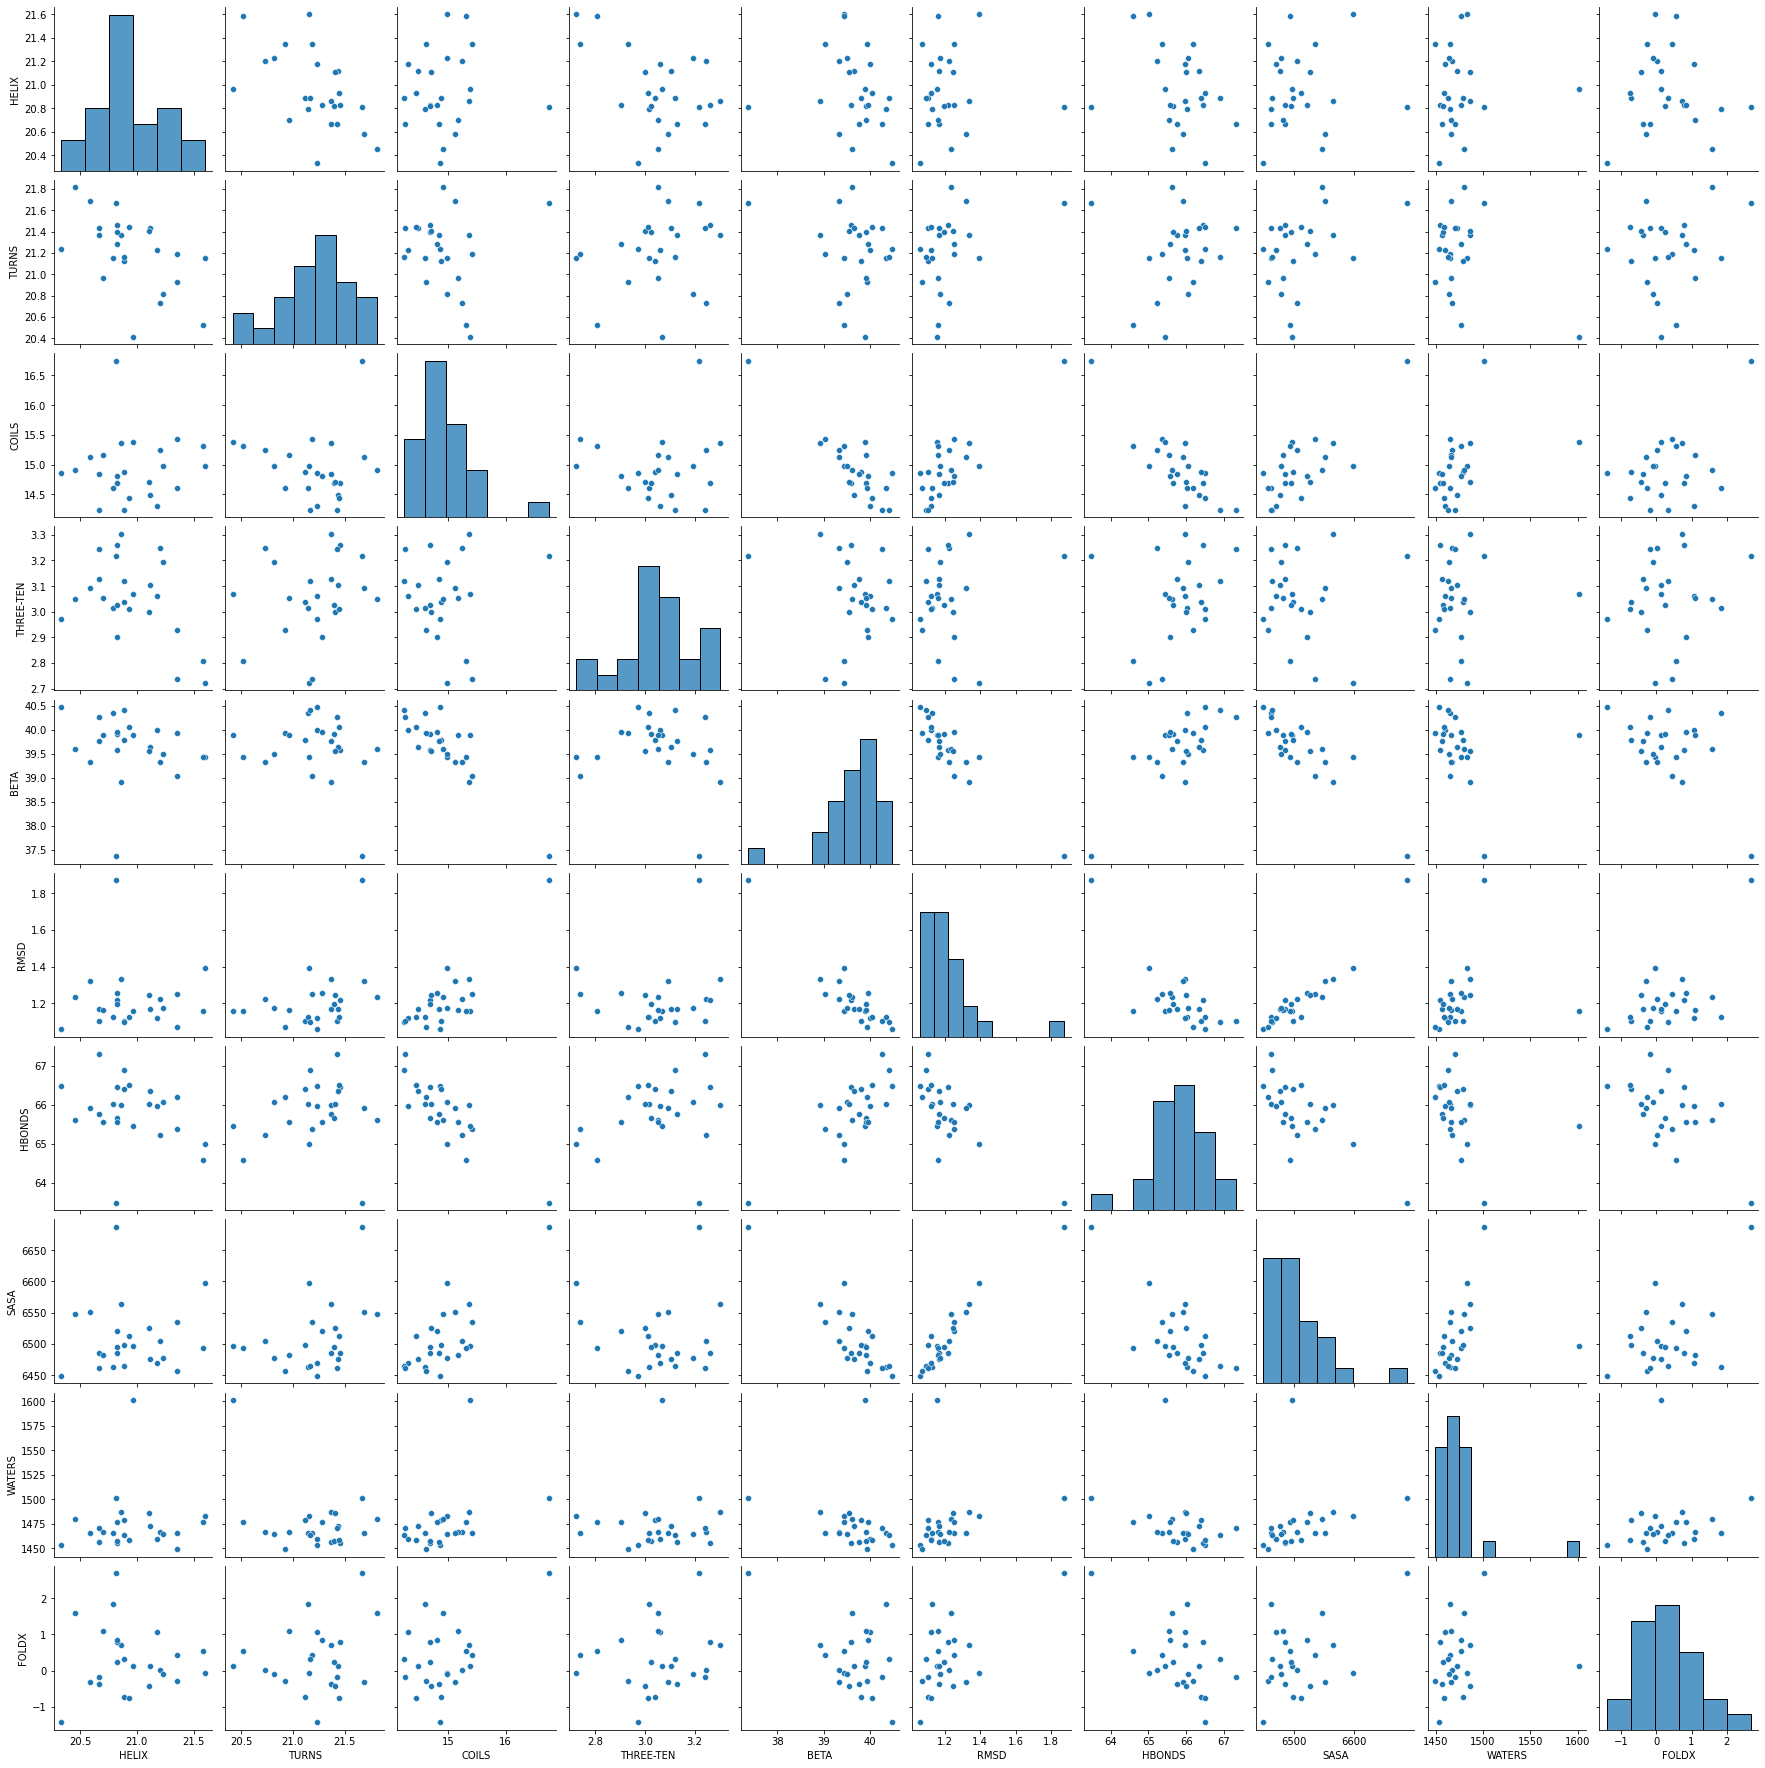

In [64]:
#plot = sns.pairplot(df_best, hue='TRAFFICKING', palette=['Red', 'Green']) 
plot = sns.pairplot(F_cole) 

#plot._legend.remove()

#plt.savefig('best-data-distribution2.pdf')